In [1]:
from correlation import getGainAndACamp, get_num_electrons
import h5py, matplotlib, glob, os
import matplotlib.pyplot as plt
from bead_util import xi, drive, time_ordered_file_list
import numpy as np
import correlation_steps as corrsteps
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# Inputs
NFFT = 2 ** 17
distance_between_plates = 0.001 # meters

In [2]:
calib = "/data/20170726/bead4_15um_QWP/calibration_47_3Hz/"
path = "/data/20170726/bead4_15um_QWP/"
pressure_path = "/data/20170726/bead4_15um_QWP/pressure"
diameter = 16.18 # micron

In [3]:
num_electrons_in_sphere = get_num_electrons(diameter)

calib_list = glob.glob(os.path.join(calib, '*.h5'))
calib_list.sort(key=os.path.getmtime)

file_list = glob.glob(os.path.join(path, '*_att.h5'))
file_list.sort(key=os.path.getmtime)

pressure_file_list = glob.glob(os.path.join(pressure_path, '*.h5'))
pressure_file_list.sort(key=os.path.getmtime)

In [4]:
def get_pressure_from_name(fname):
    i = fname.rfind('/')
    j = fname.rfind('mbar')
    if j<0:return 0
    else:
        pstr = fname[i+1:j]
        k = pstr.find('_')
        if k<0:return float(pstr)
        else:
            pstr = pstr.replace('_', '.')
            return float(pstr)
def get_pressure(fname, ps):
    p = ps[0]
    return max(p, get_pressure_from_name(fname))

In [5]:
NFFT = 2 ** 17
def getdata(fname):
    gain, ACamp = getGainAndACamp(fname, need_ACamp=False)
    f = h5py.File(fname, 'r')
    dset = f['beads/data/pos_data']
    dat = np.transpose(dset)
    Fs = dset.attrs['Fsamp']
    pressure = get_pressure(fname, dset.attrs['temps'])
    dat = dat * 10. / (2 ** 15 - 1.)
    drive_data = dat[:, drive] - np.mean(dat[:, drive])
    normalized_drive = drive_data / np.std(drive_data)
    drivepsd, freqs = matplotlib.mlab.psd(normalized_drive, Fs=Fs, NFFT=NFFT)
    x = (dat[:, xi] - np.mean(dat[:, xi]))/gain
    xpsd, freqs = matplotlib.mlab.psd(x/float(len(x)), Fs=Fs, NFFT=NFFT)
    return freqs, xpsd, drivepsd, pressure # Hz, V^2/Hz, s, mbar, V

In [6]:
def getConstant(calibration_list):
    """ normalization to units of electrons """
    i = min(len(calibration_list), 5)
    area_at_f = []
    for f in calibration_list[:i]:
        freqs, xpsd, dpsd, p = getdata(f) # Hz, V/sqrtHz, 1/sqrtHz
        start_index = np.argmin(np.abs(freqs - 47.))
        end_index = np.argmin(np.abs(freqs - 48.))
        binF = freqs[1]-freqs[0]
        area_at_f.append(binF*sum(xpsd[start_index:end_index])) # V^2
    return np.sqrt(np.average(area_at_f))*num_electrons_in_sphere # V/electron

In [7]:
def get_noise(file_list):
    """ returns theta and ratio of [response at 2f] and [drive at f] """
    pressures, area_at_f = ([] for i in range(2))
    for f in file_list:
        freqs, xpsd, drivepsd, p = getdata(f) # Hz, V/sqrtHz, 1/sqrtHz
        start_index = np.argmin(np.abs(freqs - 47.))
        end_index = np.argmin(np.abs(freqs - 48.))
        pressures.append(p) # mbar
        area_at_f.append(np.sqrt(np.average(xpsd[start_index:end_index]))) # V/sqrtHz
    return pressures, np.array(area_at_f) # mbar, V/sqrtHz

In [8]:
c = getConstant(calib_list) # V/electron
print "c = ", c

pressures, areas = get_noise(file_list) # V/sqrtHz

p_pressures, p_areas = get_noise(pressure_file_list) # V/sqrtHz

c =  4166411.84905


<IPython.core.display.Javascript object>


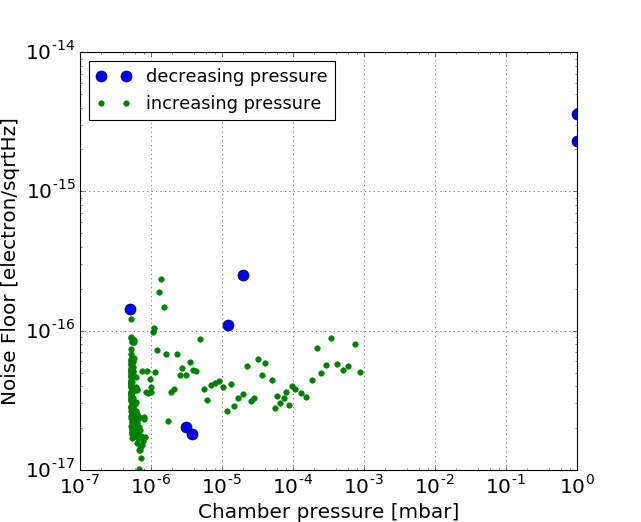

In [13]:
import matplotlib
%matplotlib notebook

plt.loglog(pressures, areas/c, 'o', markersize=10, label='decreasing pressure') # mbar, electron/sqrt(Hz)
plt.loglog(p_pressures, p_areas/c, '.', markersize=10, label='increasing pressure') # mbar, electron/sqrt(Hz)
matplotlib.rcParams.update({'font.size': 18})

plt.xlabel('Chamber pressure [mbar]')
plt.ylabel('Noise Floor [electron/sqrtHz]')
plt.legend(prop={'size': 16}, loc=2)

plt.grid()
plt.show()